In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
# Set dataset directory path
data_dir = "C:/Users/farru/Desktop/EAI 6010/Week 2/Season_dataset"

# Generate file paths and labels
filepaths = []
labels = []

# Assuming subdirectories in data_dir are the class names
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, file))
            labels.append(folder)

# Create a DataFrame with file paths and labels
df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

# Split the dataset into training, validation, and testing
train_df, test_valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(test_valid_df, train_size=0.6, shuffle=True, random_state=123)

# Define image data generator and preprocessing function
img_size = (128, 128)  # Using smaller image size for faster training
batch_size = 32  # Adjust for CPU training

def preprocess_image(img):
    return img / 255.0  # Normalizing images to [0, 1] range


In [3]:
# Define ImageDataGenerators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_image).flow_from_dataframe(
    train_df, x_col="filepaths", y_col="labels", target_size=img_size, class_mode="categorical", batch_size=batch_size
)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_image).flow_from_dataframe(
    valid_df, x_col="filepaths", y_col="labels", target_size=img_size, class_mode="categorical", batch_size=batch_size
)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_image).flow_from_dataframe(
    test_df, x_col="filepaths", y_col="labels", target_size=img_size, class_mode="categorical", batch_size=batch_size, shuffle=False
)

# Get class labels
class_labels = list(train_gen.class_indices.keys())
print(f"Class Labels: {class_labels}")


Found 5489 validated image filenames belonging to 11 classes.
Found 823 validated image filenames belonging to 11 classes.
Found 550 validated image filenames belonging to 11 classes.
Class Labels: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [5]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation="softmax")
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


In [7]:
# Train the model
epochs = 10  # Adjust as needed
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)


Epoch 1/10
172/172 [==============================] - 109s 636ms/step - loss: 0.8376 - accuracy: 0.7213 - val_loss: 1.0459 - val_accuracy: 0.6561
Epoch 2/10
172/172 [==============================] - 56s 328ms/step - loss: 0.7349 - accuracy: 0.7590 - val_loss: 0.8817 - val_accuracy: 0.7108
Epoch 3/10
172/172 [==============================] - 59s 343ms/step - loss: 0.6372 - accuracy: 0.7861 - val_loss: 0.8435 - val_accuracy: 0.7230
Epoch 4/10
172/172 [==============================] - 55s 319ms/step - loss: 0.5592 - accuracy: 0.8098 - val_loss: 0.8983 - val_accuracy: 0.7169
Epoch 5/10
172/172 [==============================] - 57s 331ms/step - loss: 0.4906 - accuracy: 0.8380 - val_loss: 0.9504 - val_accuracy: 0.7242
Epoch 6/10
172/172 [==============================] - 59s 342ms/step - loss: 0.3987 - accuracy: 0.8686 - val_loss: 1.0346 - val_accuracy: 0.6938
Epoch 7/10
172/172 [==============================] - 57s 333ms/step - loss: 0.3674 - accuracy: 0.8770 - val_loss: 1.1103 - val_a

In [8]:
# Save the entire model (architecture + weights)
model_path = "simple_model.h5"  # or use the SavedModel format
model.save(model_path)  # This saves both architecture and weights
print(f"Model saved to {model_path}")


Model saved to simple_model.h5


In [ ]:
# Save the trained model weights
#weights_path = "simple_model_weights.h5"
#model.save_weights(weights_path)
#print(f"Weights saved to {weights_path}")


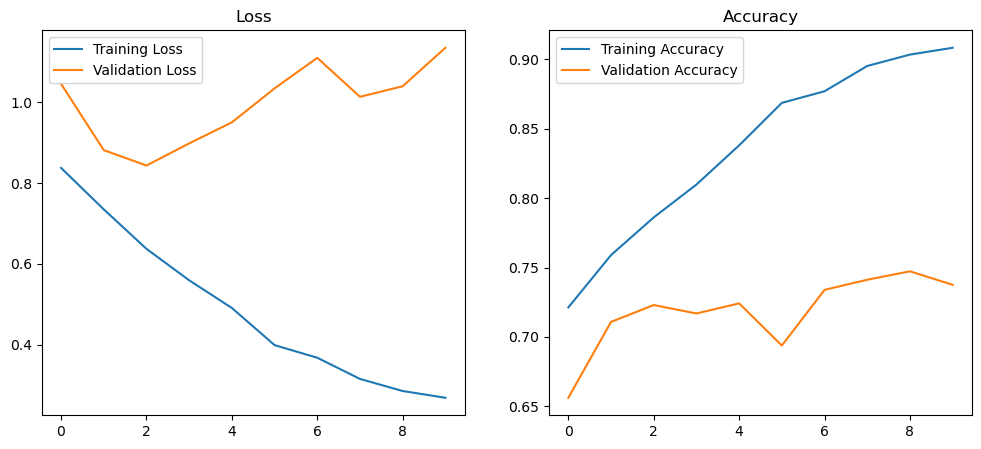

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()


In [10]:
# Test evaluation
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 7s 388ms/step - loss: 1.0458 - accuracy: 0.7509
Test Loss: 1.0458124876022339
Test Accuracy: 0.7509090900421143
